# Clustering of the claims
We will do a text analysis on the claims summary. Each claim contains a summary of what is claimed and a short summary of why this claim is wrong. Both the claim summary and disproof are written by one of the editors of EUvsDisinfo and thus always in English. This simplifies the analysis process but means we're not working with the original disinformation article. Since the original disinformation articles are in different languages, they are more difficult to compare.

## Loading the data

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords

import umap
import matplotlib.pyplot as plt

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, ColorMapper
from bokeh.palettes import Spectral10, Spectral, Set1, Viridis

plt.style.use("corrie")
output_notebook()

Loading BokehJS ...

In [2]:
clean_claims = pd.read_csv("data/clean_claimreviews.csv")
claims = pd.read_json("data/claims.json")

claims = claims.rename(columns={"@id":"id", "@type": "type"})
keywords = pd.read_csv("data/all_keywords.csv", index_col=0).rename(columns={"@id":"id", "@type": "type"})
countries = pd.read_csv("data/all_countries.csv", index_col=0).rename(columns={"@id":"id", "@type": "type"})

In [3]:
keyword_dict = dict(zip(keywords["id"], keywords["name"]))
country_dict = dict(zip(countries["id"], countries["name"]))

In [4]:
claims = claims.assign(keyword_names = [[keyword_dict[keyword] for keyword in row ] for row in claims.keywords])
claims = claims.assign(country_names = [[country_dict[country] for country in row] for row in claims.contentLocations] ) 

In [5]:
clean_claims = pd.merge(clean_claims, claims[["claimReview", "keyword_names", "country_names"]], how="left", left_on="id", right_on="claimReview")

In [6]:
clean_claims = clean_claims.drop_duplicates(subset="claimReviewed")

In [7]:
clean_claims["datePublished"] = pd.to_datetime(clean_claims.datePublished)
clean_claims["yearPublished"] = clean_claims.datePublished.dt.year

In [8]:
def pick_first(name_list):
    if name_list is np.nan or name_list is None or len(name_list) < 1:
        return "-"
    else:
        return name_list[0]

In [9]:
clean_claims = clean_claims.assign(country1 = [pick_first(countries) for countries in clean_claims.country_names],
                   keyword1 = [pick_first(keywords) for keywords in clean_claims.keyword_names])

In [10]:
clean_claims.head(3)

id                           type  \
0  /claim_reviews/20  http://schema.org/ClaimReview   
1  /claim_reviews/21  http://schema.org/ClaimReview   
2  /claim_reviews/22  http://schema.org/ClaimReview   

                                       claimReviewed  reviewRating  \
0  There are British curators behind the persecut...           NaN   
1  I would like to add that, as far as I know, Sp...           NaN   
2  We regard the actions of the regime in Estonia...           NaN   

              datePublished itemReviewed  \
0 2020-01-07 00:00:00+00:00   /claims/20   
1 2020-01-07 00:00:00+00:00   /claims/21   
2 2020-01-07 00:00:00+00:00   /claims/22   

                                                name  \
0  British curators are behind the persecution of...   
1              There are no lies coming from Sputnik   
2  The regime in Estonia publicly persecutes its ...   

                                           html_text  \
0  <p>This conspiracy theory is based on the conc...   
1  <p><a href="https://euvsdisinfo.eu/three-thing...   
2  <p>Estonia is ranked as the <a href="https://r...   

                                                text        claimReview  \
0  This conspiracy theory is based on the concept...  /claim_reviews/20   
1  Sputnik was created by a Presidential decree w...  /claim_reviews/21   
2  Estonia is ranked as the 11th freest country i...  /claim_reviews/22   

                           keyword_names country_names  yearPublished  \
0  [Dmitry Kiselyov, Sputnik, Sanctions]     [Estonia]           2020   
1  [Dmitry Kiselyov, Sputnik, Sanctions]     [Estonia]           2020   
2  [Dmitry Kiselyov, Sputnik, Sanctions]     [Estonia]           2020   

  country1         keyword1  
0  Estonia  Dmitry Kiselyov  
1  Estonia  Dmitry Kiselyov  
2  Estonia  Dmitry Kiselyov

In [11]:
clean_claims = clean_claims[clean_claims.claimReviewed.notnull()]
claim_summary = clean_claims.claimReviewed.values.tolist(); claim_summary[0]

'There are British curators behind the persecution of Sputnik [Estonia] by the Estonian authorities.'

In [12]:
clean_claims.shape

(7014, 15)

## Using Embeddings

### Pretrained Glove Word2Vec
Glove is a pretrained word embedding method on a general English language corpus.

In [13]:
from flair.data import Sentence

from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings, Sentence

# initialize the word embeddings
glove_embedding = WordEmbeddings('glove')
flair_embedding_forward = FlairEmbeddings('news-forward')
flair_embedding_backward = FlairEmbeddings('news-backward')

# initialize the document embeddings, mode = mean
document_embeddings = DocumentPoolEmbeddings([glove_embedding], fine_tune_mode="nonlinear")

In [14]:
n = len(clean_claims)

Embedd all documents:

In [15]:
sentences = [Sentence(claim) for claim in clean_claims.claimReviewed[0:n] ]

In [16]:
matrix = list()
for sentence in sentences:
    document_embeddings.embed(sentence)
    embedding = sentence.get_embedding()
    matrix.append(embedding.detach().numpy())

In [17]:
np.savetxt("data/claim_embeddings.csv", np.asarray(matrix), delimiter=",")

Next, we use UMAP to project the embeddings into a 2-dimensional space for visualizuation.

In [18]:
reducer = umap.UMAP(n_neighbors=2, metric = "cosine", random_state=2020, min_dist=0.2)

umap_embedding = reducer.fit_transform(matrix)
umap_embedding.shape


clean_claims["umap_embedding_0"] = umap_embedding[:,0]
clean_claims["umap_embedding_1"] = umap_embedding[:,1]

/home/corrie/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/home/corrie/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/lib/py

Let's plot the projection. The color is by year, darker colors correspond to more recent claims. Note that quite often multiple points are plottet on top of each other, thus later claims (darker) are often hiding older claims.

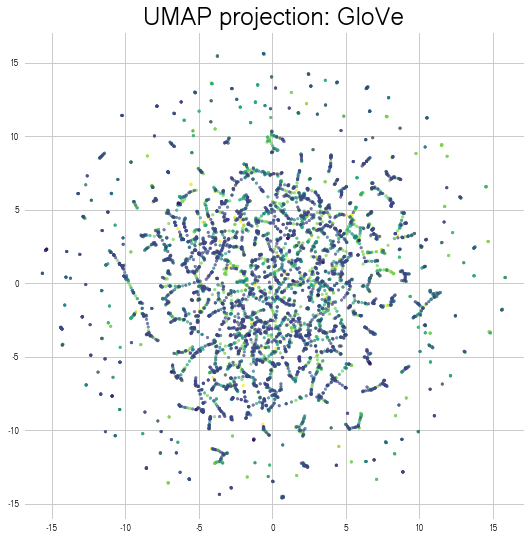

In [19]:
clean_claims.sort_values(by="yearPublished", inplace=True)
plt.figure(figsize=(9,9))
plt.scatter(clean_claims["umap_embedding_0"], clean_claims["umap_embedding_1"], s=7, 
            c=clean_claims["yearPublished"], cmap="viridis_r", alpha=0.7)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection: GloVe', fontsize=24);
plt.show()

In a static plot it is rather difficult to assess how well the clustering works. 
We thus analyse the clustering in an interactive plot to see which claims where neighbored together. The color is by year, darker colors correspond to more recent claims.

In [20]:
claim_df = pd.DataFrame(umap_embedding, columns=('x', 'y'))
claim_df['claim'] = [str(x) for x in clean_claims.claimReviewed.iloc[0:n]]
claim_df["yearPublished"] = [str(x) for x in clean_claims.yearPublished[0:n]]

datasource = ColumnDataSource(claim_df)
color_mapping = CategoricalColorMapper(factors=[str(x) for x in np.sort(clean_claims.yearPublished[0:n].unique())],
                                       palette=Viridis[6][::-1])

plot_figure = figure(
    title='UMAP projection',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div style="width:400px;">
    <span style='font-size: 14px; color: #224499'>Claim:</span>
    <span style='font-size: 12px'>@claim</span><br>
    <span style='font-size: 14px; color: #224499'>Year:</span>
    <span style='font-size: 12px'>@yearPublished</span>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    color=dict(field='yearPublished', transform=color_mapping),
    source=datasource,
    line_alpha=0.6,
    fill_alpha=0.6,
    size=10
)
show(plot_figure)

## Using Tfidf 
We can also use TfIdf, a word counting and weighting approach, to get word vectors.
We then again use UMAP to project these into a 2-dimensional space.

In [21]:
vectorizer = TfidfVectorizer(
    stop_words=stopwords.words('english'),
)

X = vectorizer.fit_transform(claim_summary)

In [22]:
mapper = umap.UMAP(metric='cosine', random_state=2405, n_neighbors=5)

umap_embedding_tfidf = mapper.fit_transform(X)

/home/corrie/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/lib/python3.7/site-packages/umap/sparse.py", line 176:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [23]:
clean_claims["tfidf_embedding_0"] = umap_embedding_tfidf[:,0]
clean_claims["tfidf_embedding_1"] = umap_embedding_tfidf[:,1]

In [24]:
clean_claims.to_csv("data/claims_w_emb.csv")

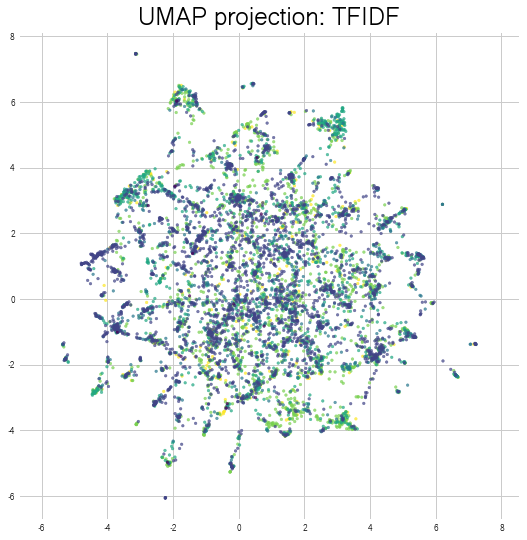

In [25]:
plt.figure(figsize=(9,9))
plt.scatter(clean_claims["tfidf_embedding_0"], clean_claims["tfidf_embedding_1"], s=7, 
            c=clean_claims["yearPublished"], alpha=0.7, cmap="viridis_r")
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection: TFIDF', fontsize=24);
plt.show()

And again, in interactive:

In [26]:
claim_df = pd.DataFrame(umap_embedding_tfidf, columns=('x', 'y'))
claim_df['claim'] = [str(x) for x in clean_claims.claimReviewed.iloc[0:n]]
#claim_df["cluster"] = [str(x) for x in clean_claims.cluster.iloc[0:n]]
claim_df["yearPublished"] = [str(x) for x in clean_claims.yearPublished[0:n]]

datasource = ColumnDataSource(claim_df)
color_mapping = CategoricalColorMapper(factors=[str(x) for x in np.sort(clean_claims.yearPublished[0:n].unique())],
                                       palette=Viridis[6][::-1])


plot_figure = figure(
    title='UMAP projection',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div style="width:400px;">
    <span style='font-size: 14px; color: #224499'>Claim:</span>
    <span style='font-size: 12px'>@claim</span><br>
    <span style='font-size: 14px; color: #224499'>Year:</span>
    <span style='font-size: 12px'>@yearPublished</span>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    color=dict(field='yearPublished', transform=color_mapping),
    source=datasource,
    line_alpha=0.6,
    fill_alpha=0.6,
    size=8
)
show(plot_figure)

## Sentence Analysis
How much to the claims represent a certain sentiment? Are they more often negative, or positive? Can we detect polarity or subjectivity in the claims?

I will use the pretrained sentiment classifier from `flair` which uses word embeddings for its classifier as well as the sentiment analysis tools from `TextBlob` which uses a rule-based approach to classify subjectivity and polarity.

### Sentiments using flair

In [27]:
from flair.models import TextClassifier
classifier = TextClassifier.load('en-sentiment')

2020-02-10 17:35:36,382 loading file /home/corrie/.flair/models/imdb-v0.4.pt


In [28]:
sentiments = list()
for sentence in sentences:
    classifier.predict(sentence)
    label = sentence.labels[0]
    if label.value == 'NEGATIVE':
        score = label.score * -1
    else:
        score = label.score
    sentiments.append(score)

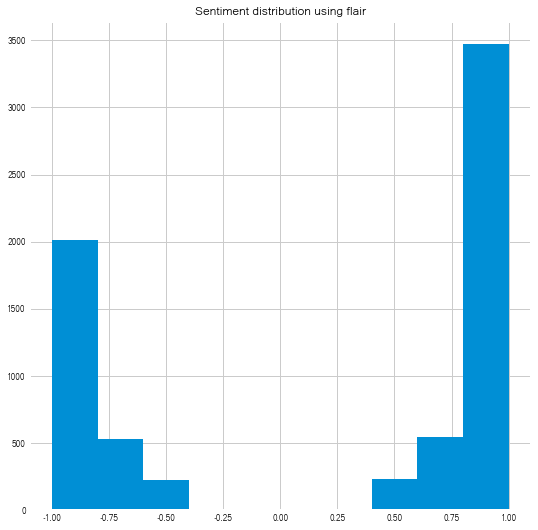

In [36]:
plt.figure(figsize=(9,9))
plt.hist(sentiments)
plt.title("Sentiment distribution using flair")
plt.show()

Most claims are predicted to have a high positive sentiment. Intuitively, I would have expected more negative sentiments but maybe there are indeed a high number of claims that paint a non-existant utopia. According to the flair sentiment analysis, the claims seem to either be strongly positive or negative.

In [30]:
clean_claims["sentiment"] = sentiments

### Using Textblob
Textblob gives a score for polarity (is the text more negative or more positive) and for the subjectivity using a rule based approach.

In [31]:
from textblob import TextBlob

textblobs = [TextBlob(claim) for claim in clean_claims.claimReviewed[0:n] ]

text_polarity = [text.sentiment.polarity for text in textblobs]
text_subjectivity = [text.sentiment.subjectivity for text in textblobs]

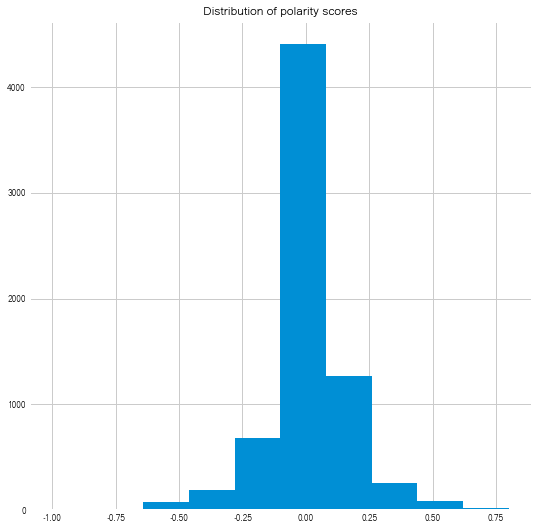

In [37]:
plt.figure(figsize=(9,9))
plt.hist(text_polarity)
plt.title("Distribution of polarity scores")
plt.show()

Negative polarity scores mean a text is negative whereas positive polarity scores mean the text is more positive.

According to TextBlob, most of the claims are neither positive nor negative, a few more slightly positive but with a longer tail for highly negative ones.

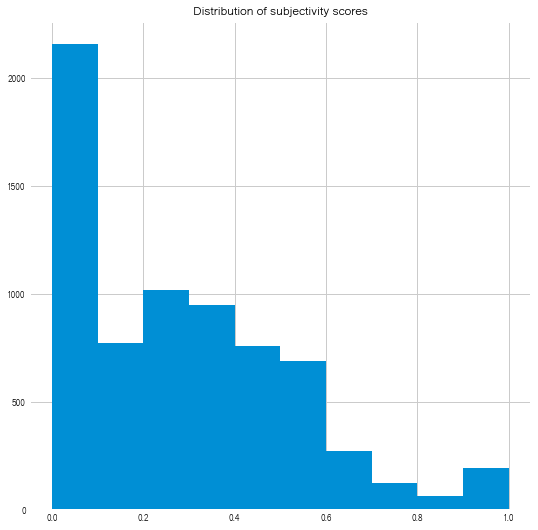

In [38]:
plt.figure(figsize=(9,9))
plt.hist(text_subjectivity)
plt.title("Distribution of subjectivity scores")
plt.show()

A low subjectivity score suggests a text is objective. TextBlob classifies most claims as objective which intuitively doesn't seem to make much sense. One problem here could be that we're only using the summary statements written  by the editor and not the orginal articles. It could be interesting to do a similar analysis on the original texts instead.

The two different methods also seem to give rather different results and more work would be needed to validate the results before drawing any conclusions.

In [34]:
clean_claims["polarity"] = text_polarity
clean_claims["subjectivity"] = text_subjectivity

In [35]:
clean_claims.to_csv("data/claims_w_sent.csv")